# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory.
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [ ]:
# Install requirements
!python -m pip install -r requirements.txt

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

from torchvision import datasets
from torch.utils.data import DataLoader

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
DATA_PATH = os.getcwd()
if "Data" not in os.listdir():
    os.makedirs('Data')
DATA_PATH = os.path.join(os.getcwd(), "Data")
print(DATA_PATH)

/content/Data


In [4]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, )),
                               transforms.RandomRotation((5, 355)),
#                                 transforms.GaussianBlur(kernel_size = (5, 5))
                               ])

# Create training set and define training dataloader
dataset = datasets.MNIST(root = DATA_PATH, train = True, transform = transform, download = True)
train_data, val_data = torch.utils.data.random_split(dataset, [50000, 10000], torch.Generator().manual_seed(42))
test_data = datasets.MNIST(root = DATA_PATH, train = False, transform = transform, download = True)

# Create test set and define test dataloader
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 32)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15835042.34it/s]


Extracting /content/Data/MNIST/raw/train-images-idx3-ubyte.gz to /content/Data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 474258.94it/s]


Extracting /content/Data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/Data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1293968.71it/s]


Extracting /content/Data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/Data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7167241.82it/s]

Extracting /content/Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/Data/MNIST/raw



## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

### transforms.ToTensor():

Deep learning models typically require input data in the form of tensors. This transformation scales the pixel values of the image from the range [0, 255] to the range [0, 1] by dividing by 255.0.

### transforms.Normalize((0.5, ), (0.5, )):

Normalization helps in speeding up the training process and achieving better convergence. It helps to standardize the inputs, making the model training more stable and efficient.

### transforms.RandomRotation((5, 355)):

Data augmentation technique used to increase the diversity of the training dataset and improve the robustness of the model.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

5


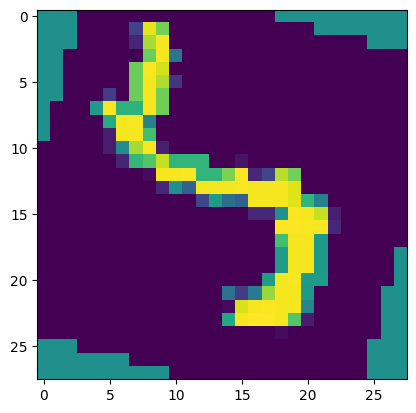

9


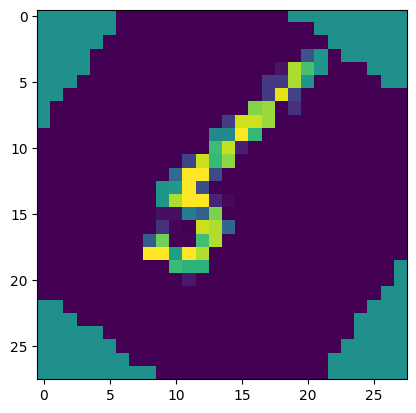

0


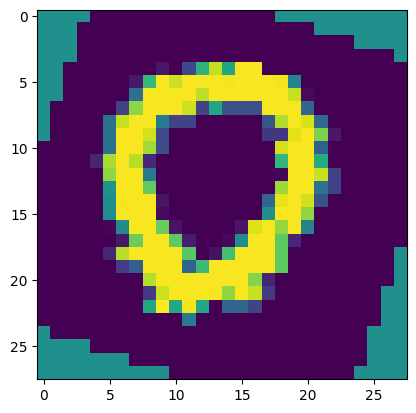

9


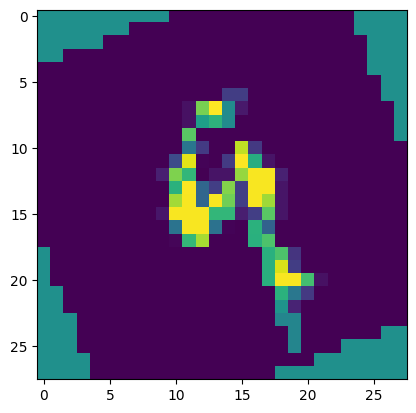

0


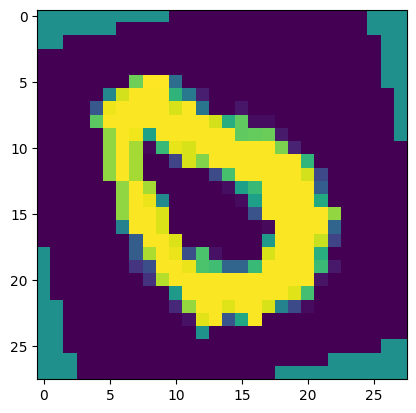

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()
show5(train_loader)

In [6]:
# Explore data
print(f"Total number of train images: {len(train_data)}")
print(f"Total number of validation images: {len(val_data)}")
print(f"Total number of test images: {len(test_data)}")

print(f"Train classes: {test_data.classes}")

print(f"Image shape: {train_data[5][0].shape}")
print("Image 5 label: {}".format(train_data[5][1]))

Total number of train images: 50000
Total number of validation images: 10000
Total number of test images: 10000
Train classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Image shape: torch.Size([1, 28, 28])
Image 5 label: 2


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like.

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
28*28

784

In [8]:
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(784, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 10)

    def forward(self, x):
        x =  torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        return x

model = model()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
def train_model(model, train_loader, val_loader, optimizer, criterion, EPOCHS = 10):
    if torch.cuda.is_available():
        model = model.cuda()

    train_losses = list()
    train_accuracy = list()

    val_losses = list()
    val_accuracy = list()

    for epoch in range(EPOCHS):
        model.train()

        train_loss = 0
        train_correct = 0

        val_loss = 0
        val_correct = 0

        for data in train_loader:
            images, labels = data

            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, predictions = torch.max(outputs.data, 1)
            train_correct += sum(predictions == labels)/len(predictions == labels)
            train_loss += loss.item()

        train_losses.append(train_loss/len(train_loader))
        train_accuracy.append(train_correct/len(train_loader))
        print(f"Epoch: {epoch+1} Train Accuracy: {(train_correct/len(train_loader)):.4f}% Train Loss: {(train_loss/len(train_loader)):.4f}")

        model.eval()

        for data in val_loader:
            images, labels = data

            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predictions = torch.max(outputs.data, 1)
            val_correct += sum(predictions == labels)/len(predictions == labels)
            val_loss += loss.item()

        val_losses.append(val_loss/len(val_loader))
        val_accuracy.append(val_correct/len(val_loader))
        print(f"Epoch: {epoch+1} Validation Accuracy: {(val_correct/len(val_loader)):.4f}% Validation Loss: {(val_loss/len(val_loader)):.4f}")
    return train_losses, train_accuracy, val_losses, val_accuracy

In [11]:
EPOCHS = 15
train_losses, train_accuracy, val_losses, val_accuracy = train_model(model, train_loader,
                                                                       val_loader, optimizer, criterion, EPOCHS)

Epoch: 1 Train Accuracy: 0.5305% Train Loss: 1.3005
Epoch: 1 Validation Accuracy: 0.6764% Validation Loss: 0.9511
Epoch: 2 Train Accuracy: 0.7880% Train Loss: 0.6514
Epoch: 2 Validation Accuracy: 0.8496% Validation Loss: 0.4782
Epoch: 3 Train Accuracy: 0.8571% Train Loss: 0.4516
Epoch: 3 Validation Accuracy: 0.8777% Validation Loss: 0.3921
Epoch: 4 Train Accuracy: 0.8869% Train Loss: 0.3608
Epoch: 4 Validation Accuracy: 0.9013% Validation Loss: 0.3170
Epoch: 5 Train Accuracy: 0.8981% Train Loss: 0.3161
Epoch: 5 Validation Accuracy: 0.9038% Validation Loss: 0.3186
Epoch: 6 Train Accuracy: 0.9108% Train Loss: 0.2818
Epoch: 6 Validation Accuracy: 0.9036% Validation Loss: 0.2973
Epoch: 7 Train Accuracy: 0.9190% Train Loss: 0.2573
Epoch: 7 Validation Accuracy: 0.9220% Validation Loss: 0.2428
Epoch: 8 Train Accuracy: 0.9237% Train Loss: 0.2344
Epoch: 8 Validation Accuracy: 0.9262% Validation Loss: 0.2367
Epoch: 9 Train Accuracy: 0.9293% Train Loss: 0.2226
Epoch: 9 Validation Accuracy: 0.9299

Plot the training loss (and validation loss/accuracy, if recorded).

In [23]:
train_accuracy = [_.cpu().numpy() for _ in train_accuracy]
val_accuracy = [_.cpu().numpy() for _ in val_accuracy]

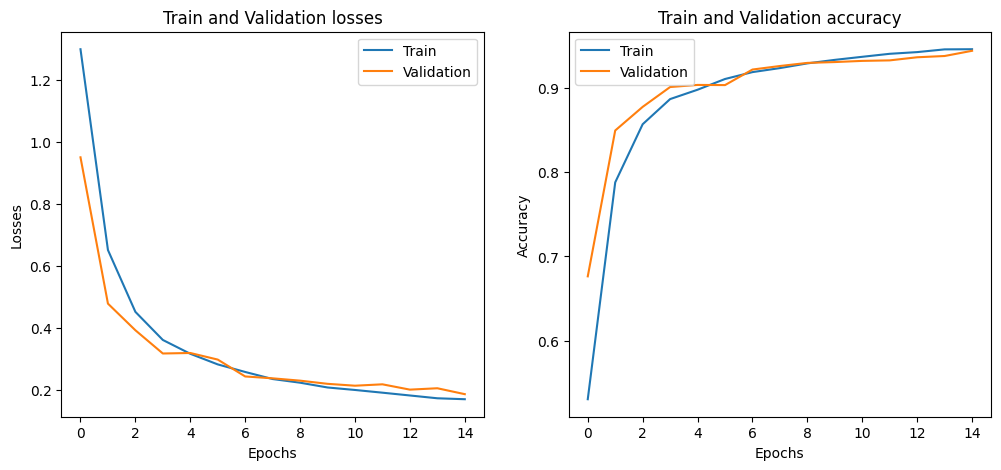

In [24]:
## YOUR CODE HERE ##
def plot_loss_accuracy(train_losses, train_accuracy, val_losses, val_accuracy):
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Train", "Validation"])
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.title("Train and Validation losses")

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.legend(["Train", "Validation"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train and Validation accuracy")
plot_loss_accuracy(train_losses, train_accuracy, val_losses, val_accuracy)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 90%, great work, but see if you can push a bit further!
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [26]:
test_correct = 0
for data in test_loader:
    images, labels = data

    if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()

    outputs = model(images)

    _, predictions = torch.max(outputs.data, 1)
    test_correct += sum(predictions == labels)/len(predictions == labels)

print("The test accuracy is: {}".format(test_correct/len(test_loader)))

The test accuracy is: 0.9477835297584534


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

#### Increased the number of layers and epochs. Also reduced the learning rate

In [27]:
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(784, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 10)

    def forward(self, x):
        x =  torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.activation(self.layer4(x))
        return self.layer5(x)

# Initialize the network, loss function, and optimizer
new_model = model()

optimizer = optim.SGD(new_model.parameters(), lr=0.005, momentum=0.9)

In [28]:
EPOCHS = 20
new_train_losses, new_train_accuracy, new_val_losses, new_val_accuracy = train_model(new_model, train_loader,
                                                                                      val_loader, optimizer, criterion, EPOCHS)

Epoch: 1 Train Accuracy: 0.4142% Train Loss: 1.5797
Epoch: 1 Validation Accuracy: 0.5547% Validation Loss: 1.2547
Epoch: 2 Train Accuracy: 0.6443% Train Loss: 1.0329
Epoch: 2 Validation Accuracy: 0.7422% Validation Loss: 0.7751
Epoch: 3 Train Accuracy: 0.8005% Train Loss: 0.6177
Epoch: 3 Validation Accuracy: 0.8317% Validation Loss: 0.5446
Epoch: 4 Train Accuracy: 0.8545% Train Loss: 0.4607
Epoch: 4 Validation Accuracy: 0.8668% Validation Loss: 0.4364
Epoch: 5 Train Accuracy: 0.8797% Train Loss: 0.3787
Epoch: 5 Validation Accuracy: 0.8820% Validation Loss: 0.3750
Epoch: 6 Train Accuracy: 0.8964% Train Loss: 0.3255
Epoch: 6 Validation Accuracy: 0.8925% Validation Loss: 0.3408
Epoch: 7 Train Accuracy: 0.9079% Train Loss: 0.2923
Epoch: 7 Validation Accuracy: 0.9127% Validation Loss: 0.2857
Epoch: 8 Train Accuracy: 0.9157% Train Loss: 0.2651
Epoch: 8 Validation Accuracy: 0.9201% Validation Loss: 0.2615
Epoch: 9 Train Accuracy: 0.9244% Train Loss: 0.2424
Epoch: 9 Validation Accuracy: 0.9165

In [31]:
new_train_accuracy = [_.cpu().numpy() for _ in new_train_accuracy]
new_val_accuracy = [_.cpu().numpy() for _ in new_val_accuracy]

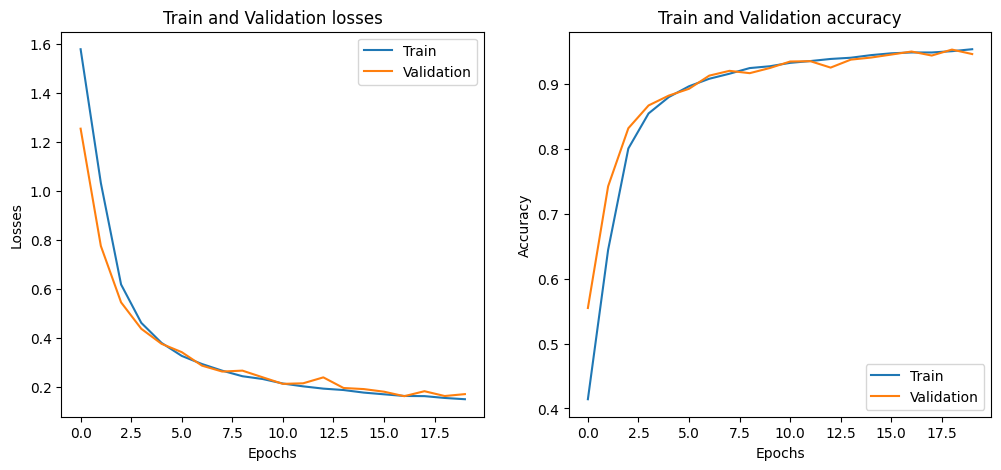

In [32]:
plot_loss_accuracy(new_train_losses, new_train_accuracy, new_val_losses, new_val_accuracy)

In [33]:
test_correct = 0
for data in test_loader:
    images, labels = data

    if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()

    outputs = new_model(images)

    _, predictions = torch.max(outputs.data, 1)
    test_correct += sum(predictions == labels)/len(predictions == labels)

print("The new test accuracy is: {}".format(test_correct/len(test_loader)))

The new test accuracy is: 0.9527755379676819


## Saving your model
Using `torch.save`, save your model for future loading.

In [34]:
MODEL_PATH = os.getcwd()
if "Models" not in os.listdir():
    os.makedirs('Models')
MODEL_PATH = os.path.join(os.getcwd(), "Models\\model.pth")
torch.save(model, MODEL_PATH)